/tmp/ipykernel_1034/2744878292.py:37: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  joint_avg_u = np.average(df1['u'].append(df2['u']))
/tmp/ipykernel_1034/2744878292.py:38: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  joint_avg_y = np.average(df1['y'].append(df2['y']))
/tmp/ipykernel_1034/2744878292.py:39: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  joint_std_u = np.std(df1['u'].append(df2['u']))
/tmp/ipykernel_1034/2744878292.py:40: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  joint_std_y = np.std(df1['y'].append(df2['y']))


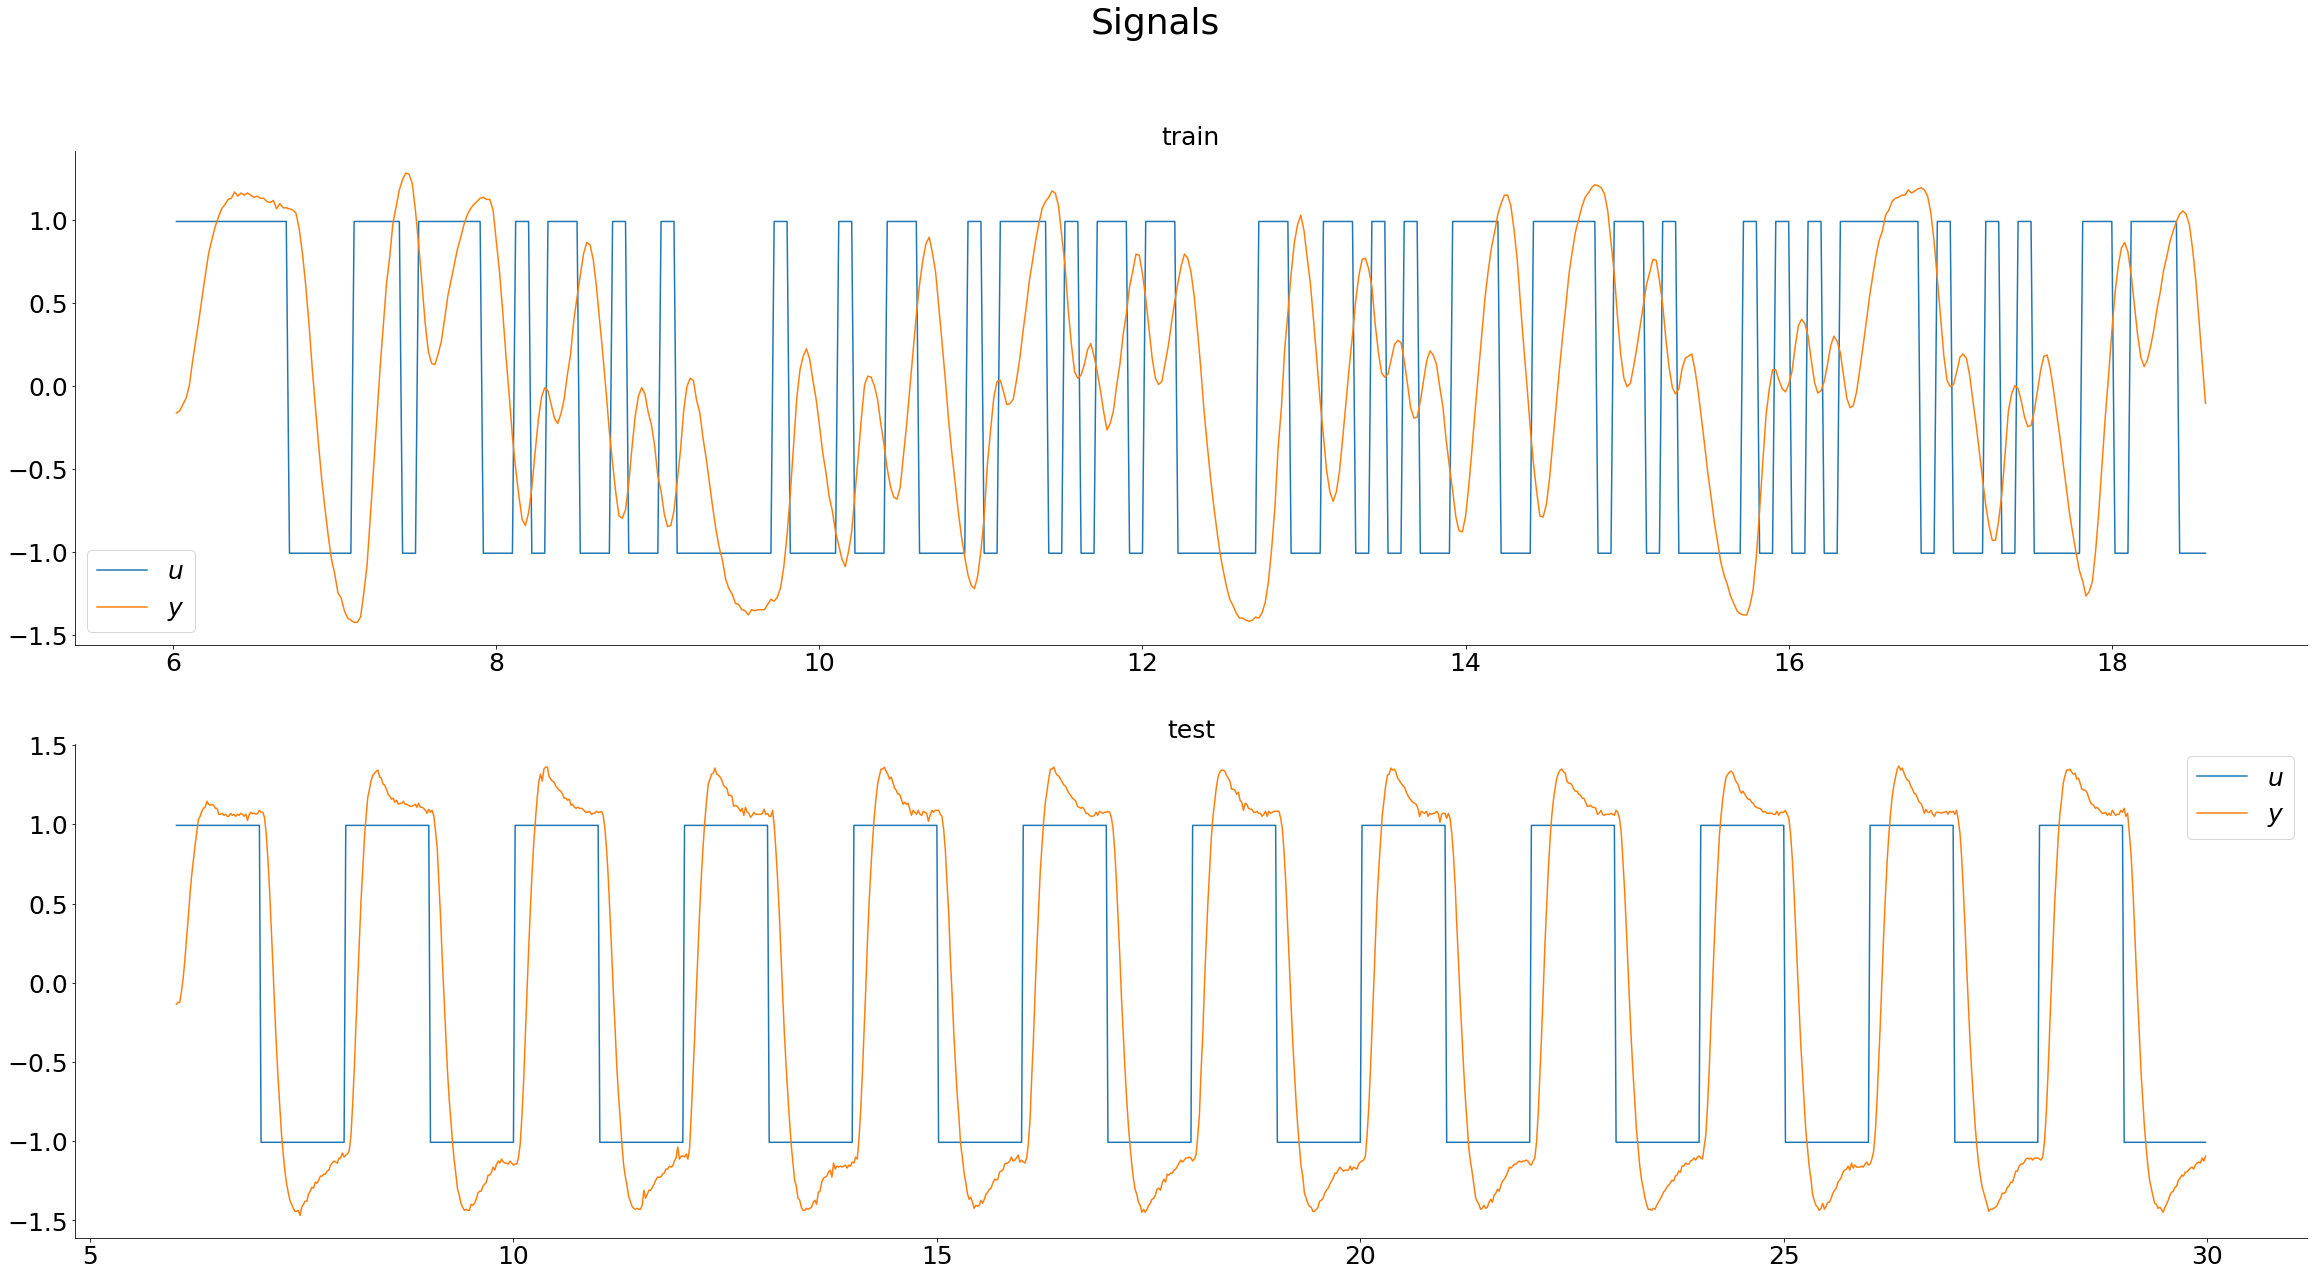

In [17]:
import copy

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy as sc
import scipy.signal
import scipy.stats
#import sysidentpy as sipy
from scipy.fft import fft, ifft, fftshift
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from sklearn.metrics import mutual_info_score

from sysidentpy.metrics import mean_squared_error
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function._basis_function import Polynomial
from sysidentpy.utils.display_results import results
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import compute_residues_autocorrelation, compute_cross_correlation

plt.rc('font', size=30)          # controls default text sizes
plt.rc('axes', titlesize=25)     # fontsize of the axes title
plt.rc('axes', labelsize=25)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=25)    # fontsize of the tick labels
plt.rc('ytick', labelsize=25)    # fontsize of the tick labels
plt.rc('legend', fontsize=25)    # legend fontsize

df1 = pd.read_csv('data/U3.ASC', sep="\s+", names=['time', 'y', 'u'])
df2 = pd.read_csv('data/U1.ASC', sep="\s+", names=['time', 'y', 'u'])

# cut
df1 = df1.iloc[301:1500]
df2 = df2.iloc[301:930]

# z-normalise
joint_avg_u = np.average(df1['u'].append(df2['u']))
joint_avg_y = np.average(df1['y'].append(df2['y']))
joint_std_u = np.std(df1['u'].append(df2['u']))
joint_std_y = np.std(df1['y'].append(df2['y']))
df1['u'] = (df1['u']-joint_avg_u)/joint_std_u
df1['y'] = (df1['y']-joint_avg_y)/joint_std_y
df2['u'] = (df2['u']-joint_avg_u)/joint_std_u
df2['y'] = (df2['y']-joint_avg_y)/joint_std_y

u_train = np.asarray(df2['u']).reshape(-1, 1)
u_valid = np.asarray(df1['u']).reshape(-1, 1)
y_train = np.asarray(df2['y']).reshape(-1,1)
y_valid = np.asarray(df1['y']).reshape(-1,1)

fig, axn = plt.subplots(2,1,figsize=(40,20))
title = 'Signals'
fig.suptitle(title)
axn[0].plot(df2['time'], u_train, label=r'$u$')
axn[0].plot(df2['time'], y_train, label=r'$y$')
axn[0].set_title('train')
axn[0].legend()
axn[1].plot(df1['time'], u_valid, label=r'$u$')
axn[1].plot(df1['time'], y_valid, label=r'$y$')
axn[1].set_title('test')
axn[1].legend()
#plt.savefig('figs/{}.eps'.format(title))
plt.show()


# Basic implementation of ARX model

/home/kreljo/anaconda3/lib/python3.9/site-packages/sysidentpy/utils/deprecation.py:37: FutureWarning: Passing a string to define the estimator will rise an error in v0.4.0. 
 You'll have to use FROLS(estimator=LeastSquares()) instead. 
 The only change is that you'll have to define the estimator first instead of passing a string like 'least_squares'. 
 This change will make easier to implement new estimators and it'll improve code readability.
  warnings.warn(message, FutureWarning)


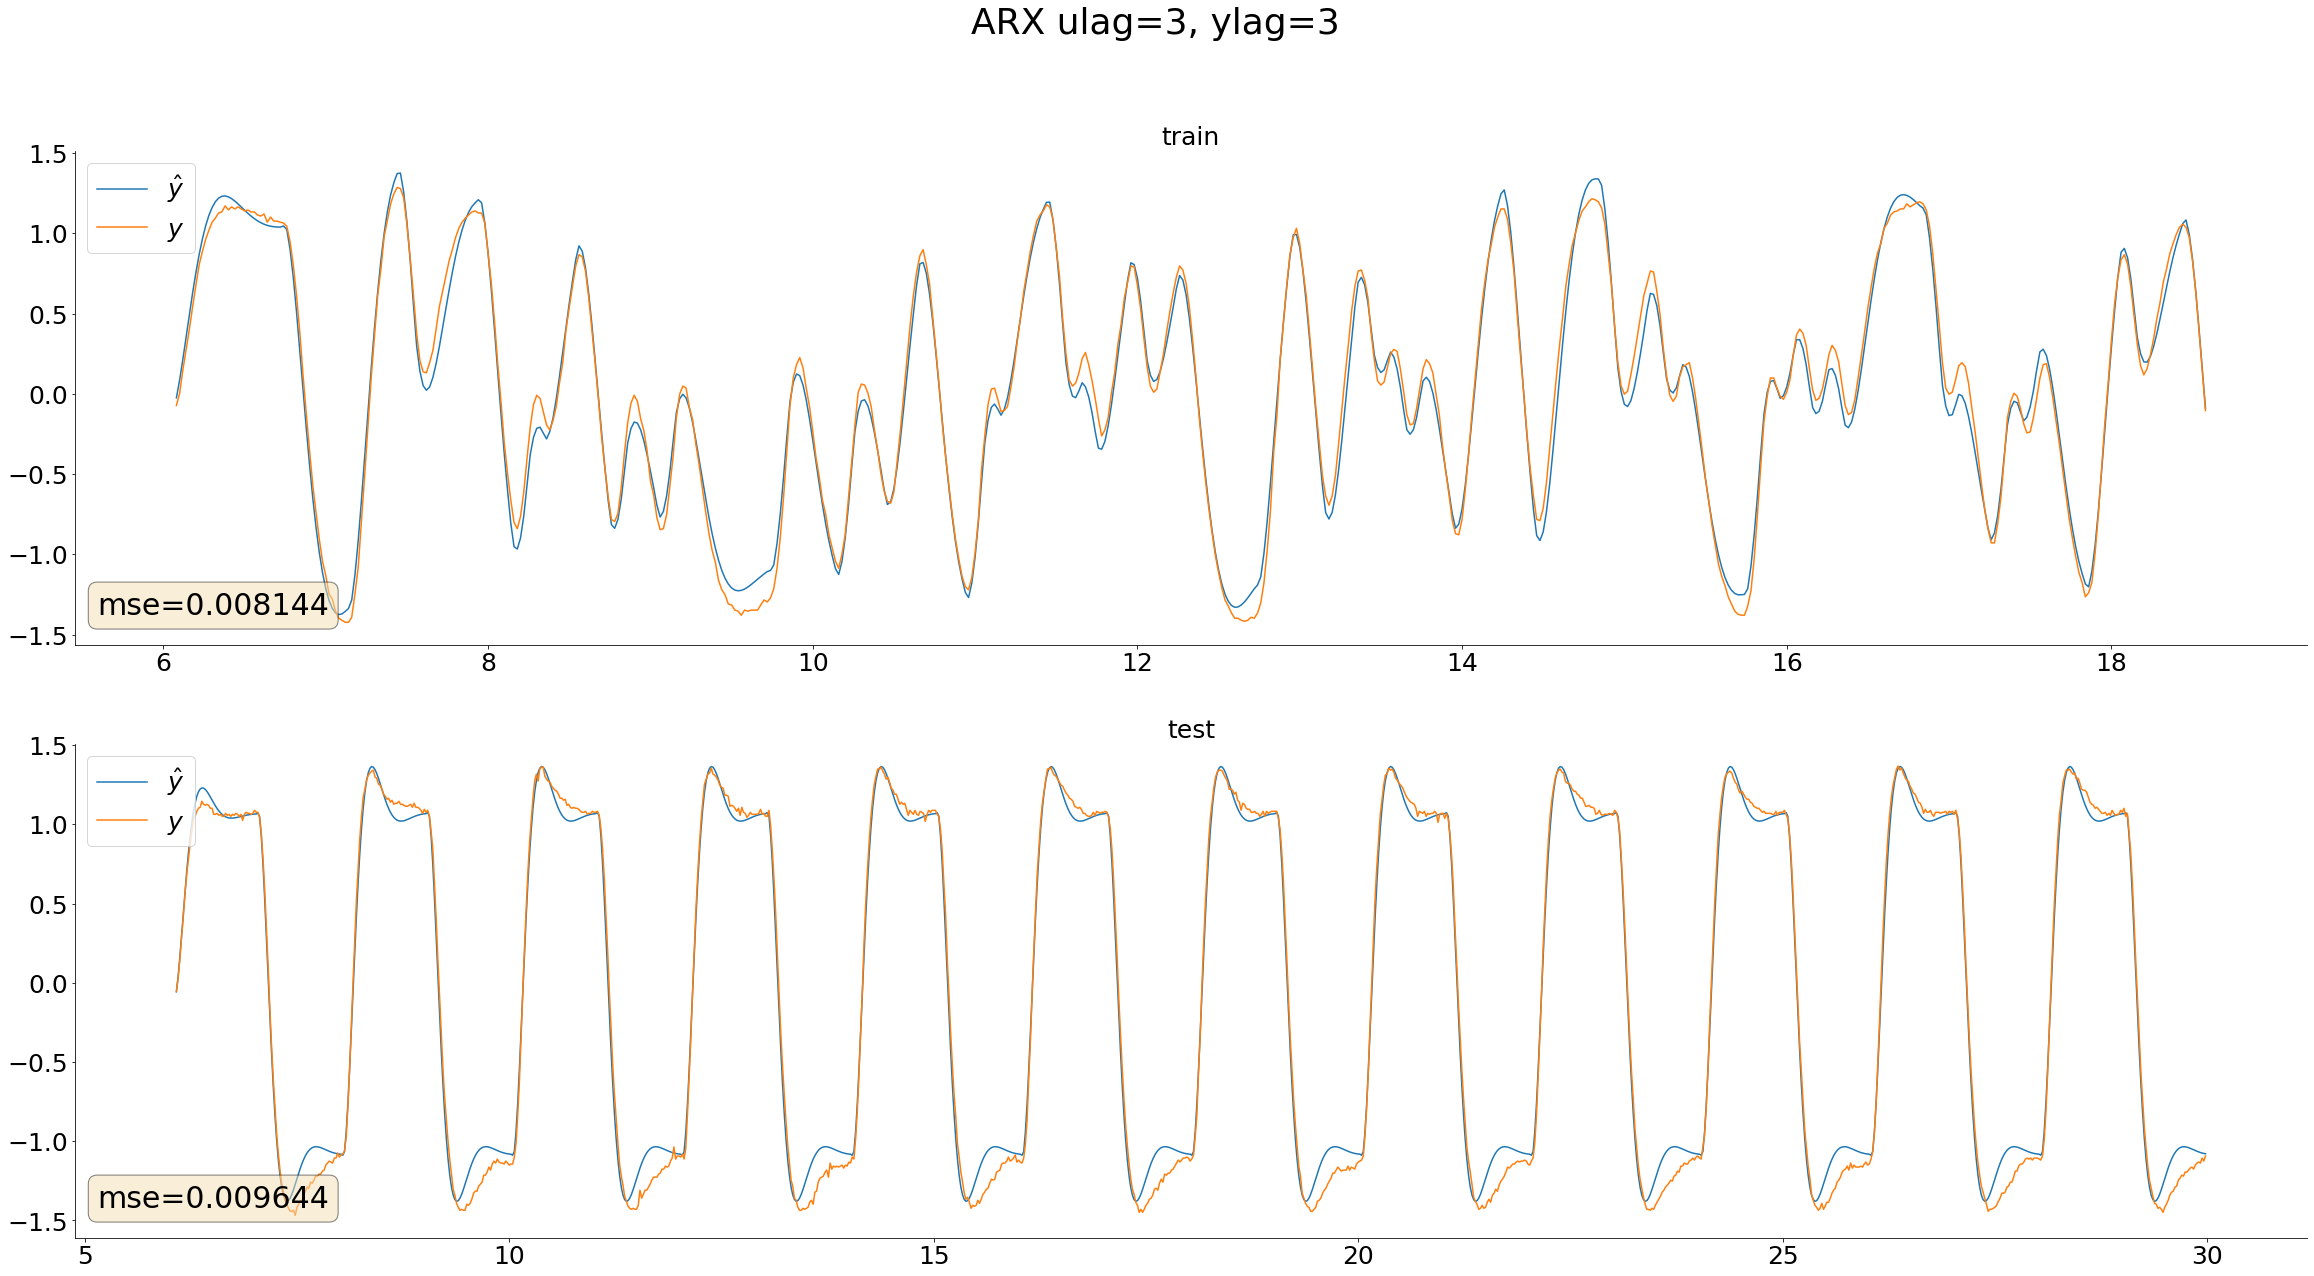

In [43]:
ylag = 3
ulag = 3
lag = max(ulag,ylag)

model = FROLS(
    ylag=ylag,
    xlag=ulag,
    n_terms=ylag+ulag,
    estimator='least_squares',
    extended_least_squares=False,
    basis_function=Polynomial(degree=1) # linear
)
model.fit(X=u_train, y=y_train)

yhat_train = model._n_step_ahead_prediction(X=u_train, y=y_train[:lag], steps_ahead=len(y_train) - lag)
yhat_valid = model._n_step_ahead_prediction(X=u_valid, y=y_valid[:lag], steps_ahead=len(y_valid) - lag)

mse_train = mean_squared_error(y_train[lag:], yhat_train)
mse_valid = mean_squared_error(y_valid[lag:], yhat_valid)

fig, axn = plt.subplots(2,1,figsize=(40,20))
title = 'ARX ulag={}, ylag={}'.format(ulag, ylag)
fig.suptitle(title)
axn[0].plot(df2['time'][lag:], yhat_train, label=r'$\hat{y}$')
axn[0].plot(df2['time'][lag:], y_train[lag:], label=r'$y$')
axn[0].set_title('train')
axn[0].legend(loc=2)
axn[0].text(0.01, 0.05, 'mse={}'.format(round(mse_train,6)), transform=axn[0].transAxes, verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
axn[1].plot(df1['time'][lag:], yhat_valid, label=r'$\hat{y}$')
axn[1].plot(df1['time'][lag:], y_valid[lag:], label=r'$y$')
axn[1].set_title('test')
axn[1].legend(loc=2)
axn[1].text(0.01, 0.05, 'mse={}'.format(round(mse_valid,6)), transform=axn[1].transAxes, verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
#plt.savefig('figs/{}.eps'.format(title))
plt.show()

r = pd.DataFrame(
    results(
        model.final_model, model.theta, model.err,
        model.n_terms, err_precision=8, dtype='sci'
        ),
    columns=['Regressors', 'Parameters', 'ERR'])

# Residual analysis: $R_{\epsilon}$ and $R_{\epsilon u}$
### Here the idea is to check, firstly, if the residuals are distributed as white noise, and secondly, if the residuals are independent of input u. For the second case, if not true, then the information content of u is not maximally implemented in the model, i.e., the model is not optimal.

        lb_stat  lb_pvalue
10  1977.425573        0.0
ADF Statistic: -7.049461602520253
p-value: 5.575100028525618e-10 
---------------------
Significant correlations at lags: []
Pearson correlation: -0.029189721356737346, p-value: 0.46598803280471873
Spearman correlation: -0.019245819416482884, p-value: 0.6307920314521889
Mutual information: 0.6930655198532911


/home/kreljo/anaconda3/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


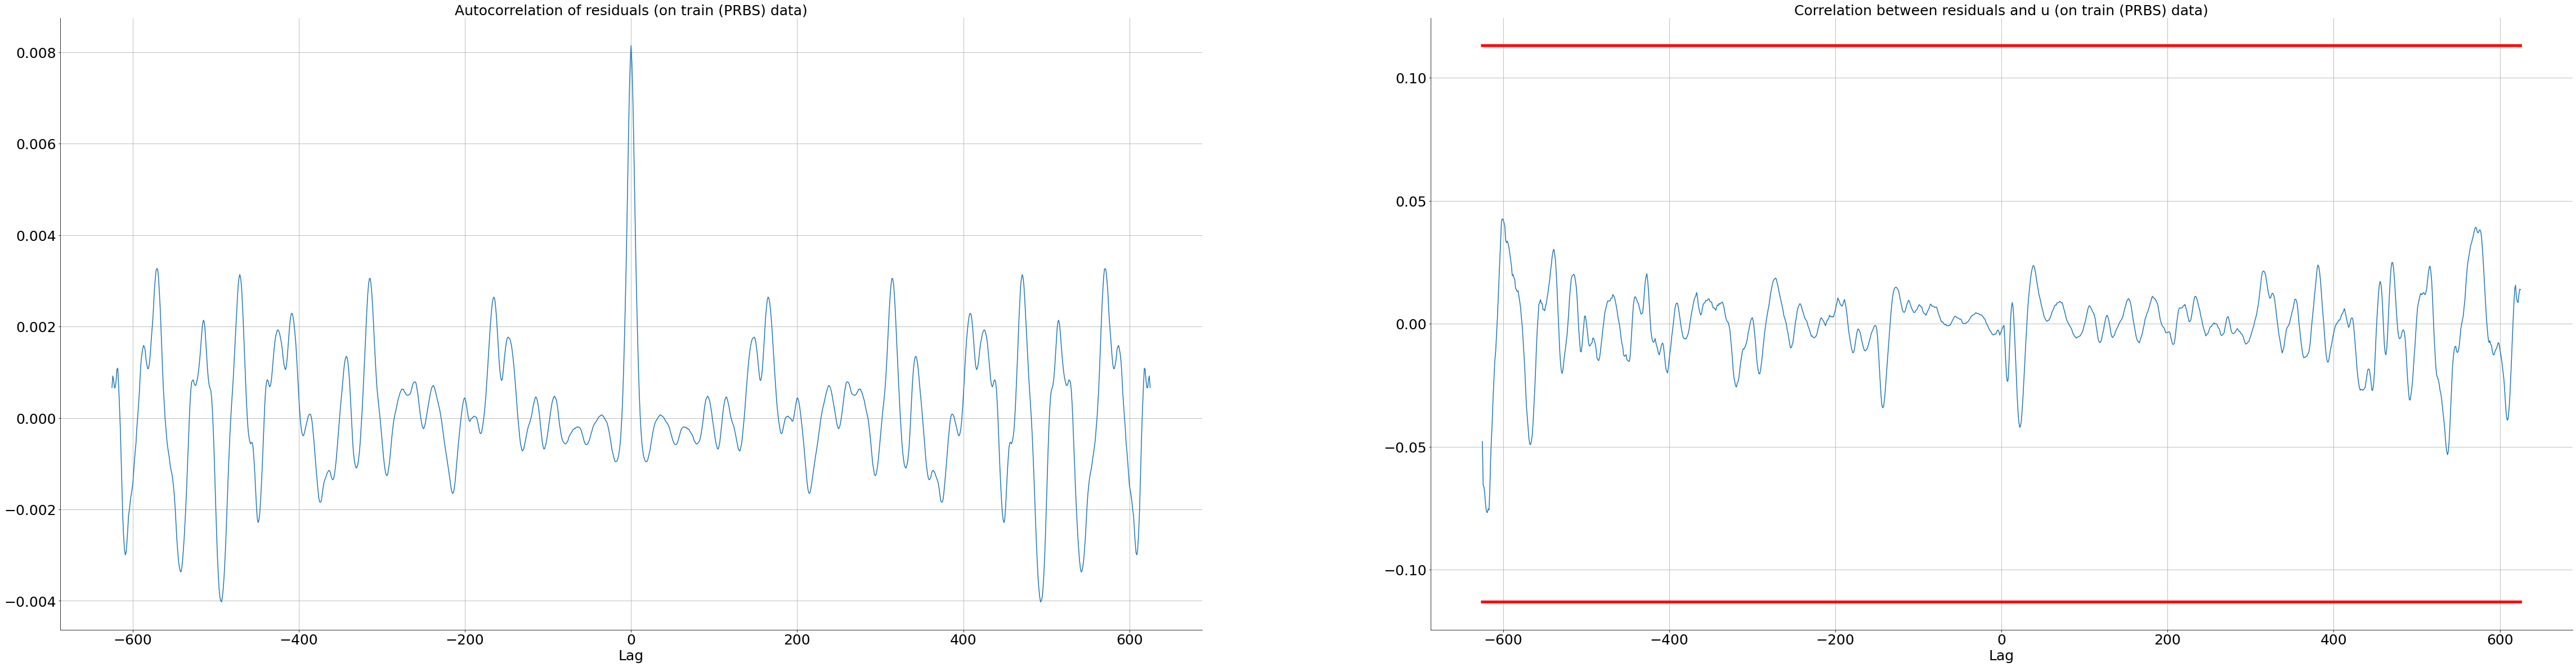

In [44]:
e_train = (yhat_train - y_train[lag:]).reshape(-1)
l = len(e_train)
lags = np.arange(-l + 1, l)


#------- white noise test (Ljung, pg. 512) ------------------

# R_epsilon
# R_e = []
# for i in range(l):
#     R_e.append(np.sum(1 / (l - i) * e_train[:l - i] * e_train[i:]))
R_e = sc.signal.correlate(e_train, e_train, mode='full')

# calculate the number of overlapping points at each lag
overlap_e = np.correlate(np.ones_like(e_train), np.ones_like(e_train), mode='full')

R_e = R_e / overlap_e

# perform the Ljung-Box test
ljung_box = sm.stats.diagnostic.acorr_ljungbox(e_train, lags=[10], return_df=True)
print(ljung_box)

# perform the Augmented Dickey-Fuller test
adf_test = adfuller(e_train)
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}', '\n---------------------')

fig, axn = plt.subplots(1,2,figsize=(80,20))
axn[0].plot(lags,R_e)
axn[0].set_title('Autocorrelation of residuals (on train (PRBS) data)')
axn[0].set_xlabel('Lag')
axn[0].grid(True)

#------- u, e independence test --------------

# R_epsilon,u
R_eu = scipy.signal.correlate(e_train, u_train[lag:, 0], mode='full')

# calculate the number of overlapping points at each lag
overlap_eu = np.correlate(np.ones_like(e_train), np.ones_like(u_train[lag:, 0]), mode='full')

R_eu = R_eu / overlap_eu

# remove lag zero
zero_lag_index = np.where(lags == 0)[0][0]
R_eu = np.delete(R_eu, zero_lag_index)
lags = np.delete(lags, zero_lag_index)

# Check the statistical significance of the correlations
# If all correlations are zero, then `a` and `b` are statistically independent
stat_sig = 2 / np.sqrt(l/2)
significant_correlations = np.where(np.abs(R_eu) > stat_sig)
print("Significant correlations at lags:", lags[significant_correlations])

# pearson
corr, p_value = sc.stats.pearsonr(e_train, u_train[lag:, 0])
print(f'Pearson correlation: {corr}, p-value: {p_value}')

# spearman
corr, p_value = scipy.stats.spearmanr(e_train, u_train[lag:, 0])
print(f'Spearman correlation: {corr}, p-value: {p_value}')

# mutal information
mi = mutual_info_score(e_train, u_train[lag:, 0])
print(f'Mutual information: {mi}')

axn[1].plot(lags,R_eu)
axn[1].plot(lags, [stat_sig for i in range(len(lags))], lw=5, c='r')
axn[1].plot(lags, [-stat_sig for i in range(len(lags))], lw=5, c='r')
axn[1].set_title('Correlation between residuals and u (on train (PRBS) data)')
axn[1].set_xlabel('Lag')
axn[1].grid(True)

### The results show that the residuals cannot be described as an instance of white noise process. However, the correlation between e and u shows, that the residuals do not depend largely on the lagged inputs of u, both for positive and negative lags.

### We can trade off some of the model accuracy for model simplicity by introducing an information criteria such as Akaike Information Criteria (AIC) (can be chosen as an argument of FROLS), e.g. keeping half of the regeressors:

/home/kreljo/anaconda3/lib/python3.9/site-packages/sysidentpy/utils/deprecation.py:37: FutureWarning: Passing a string to define the estimator will rise an error in v0.4.0. 
 You'll have to use FROLS(estimator=LeastSquares()) instead. 
 The only change is that you'll have to define the estimator first instead of passing a string like 'least_squares'. 
 This change will make easier to implement new estimators and it'll improve code readability.
  warnings.warn(message, FutureWarning)


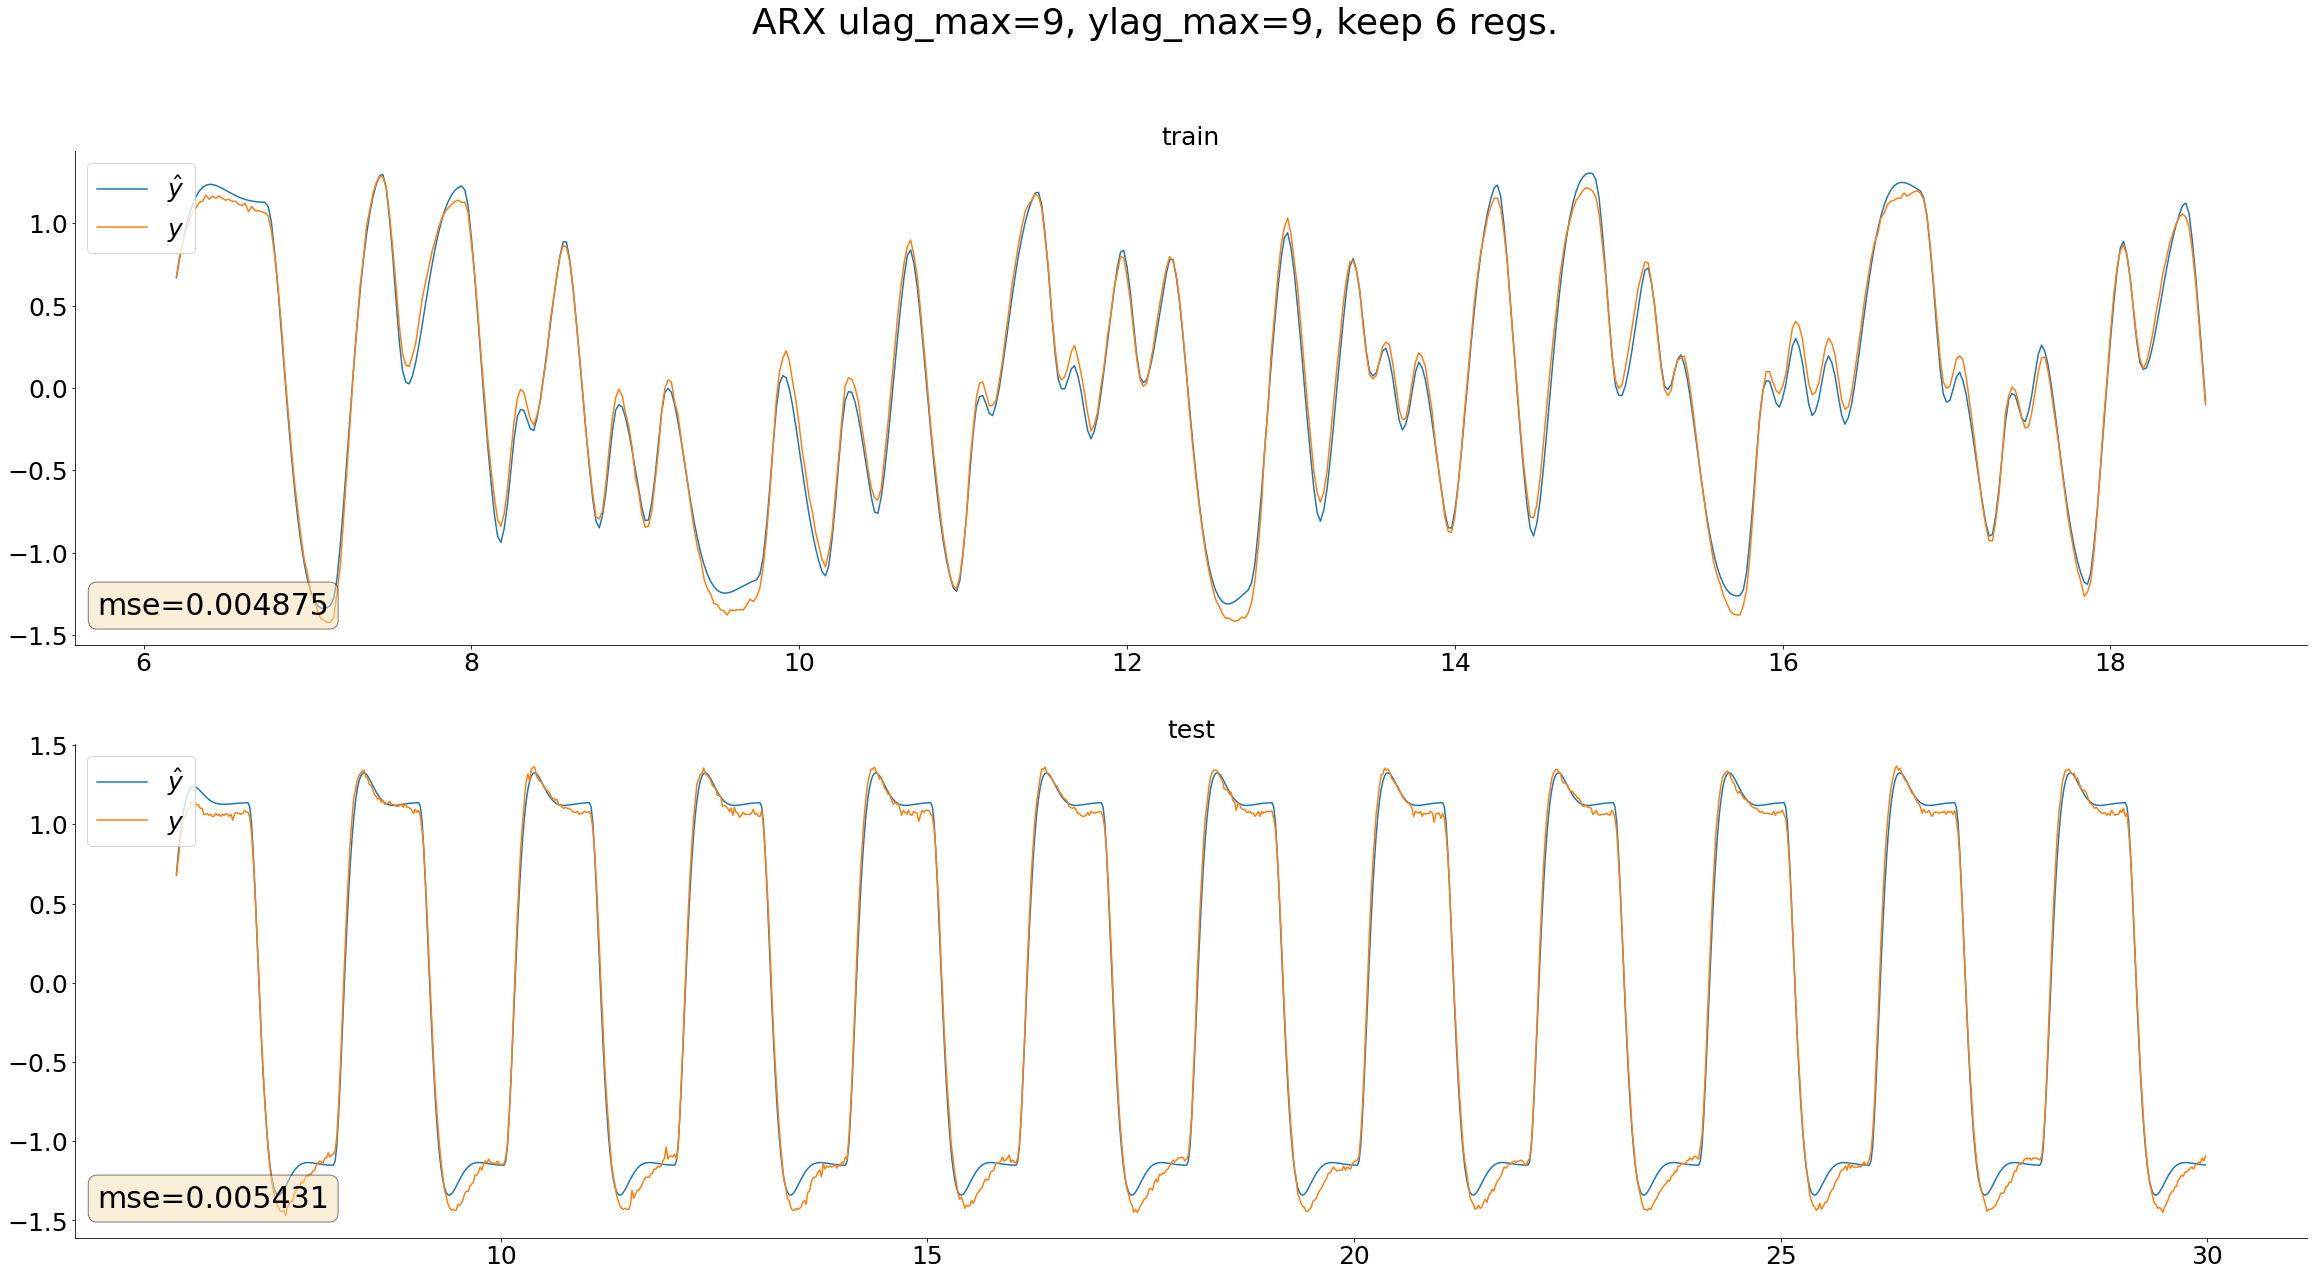

In [42]:
ylag = 9
ulag = 9
elag = 9
lag = max(ulag,ylag,elag)
keep_n_regressors = 6

model = FROLS(
    ylag=ylag,
    xlag=ulag,
    elag=elag,
    order_selection=True,
    info_criteria='aic', # Akaike Information Criterion
    n_info_values=keep_n_regressors,
    estimator='least_squares',
    extended_least_squares=False,
    basis_function=Polynomial(degree=1) # linear
)
model.fit(X=u_train, y=y_train)

yhat_train = model._n_step_ahead_prediction(X=u_train, y=y_train[:lag], steps_ahead=len(y_train) - lag)
yhat_valid = model._n_step_ahead_prediction(X=u_valid, y=y_valid[:lag], steps_ahead=len(y_valid) - lag)

mse_train = mean_squared_error(y_train[lag:], yhat_train)
mse_valid = mean_squared_error(y_valid[lag:], yhat_valid)

fig, axn = plt.subplots(2,1,figsize=(40,20))
title = 'ARX ulag_max={}, ylag_max={}, keep {} regs.'.format(ulag, ylag, keep_n_regressors)
fig.suptitle(title)
axn[0].plot(df2['time'][lag:], yhat_train, label=r'$\hat{y}$')
axn[0].plot(df2['time'][lag:], y_train[lag:], label=r'$y$')
axn[0].set_title('train')
axn[0].legend(loc=2)
axn[0].text(0.01, 0.05, 'mse={}'.format(round(mse_train,6)), transform=axn[0].transAxes, verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
axn[1].plot(df1['time'][lag:], yhat_valid, label=r'$\hat{y}$')
axn[1].plot(df1['time'][lag:], y_valid[lag:], label=r'$y$')
axn[1].set_title('test')
axn[1].legend(loc=2)
axn[1].text(0.01, 0.05, 'mse={}'.format(round(mse_valid,6)), transform=axn[1].transAxes, verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
#plt.savefig('figs/{}.eps'.format(title))
plt.show()

### can lead to similar performance but less complex and more interpretable model